In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, UpSampling2D 
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, LeakyReLU, Dense, Reshape, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

import os
import time
from datetime import datetime

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image 

from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

import pandas as pd

from matplotlib import pyplot

from numpy import load

from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
data=[]

for filename in os.listdir('part1'):
  parts=filename.split('_')
  #print(parts[3])
  item={}
  item['image']=filename
  item['age']=parts[0]
  item['gender']=parts[1]
  item['race']=parts[2]
  if (len(parts)==4):
    item['date_time']=parts[3]
  data.append(item)
  
utk_data=pd.DataFrame(data)  
utk_data.describe() 

image    age gender   race  \
count                           24108  24108  24108  24108   
unique                          24108    104      4      8   
top     100_0_0_20170112213500903.jpg     26      0      0   
freq                                1   2206  12582  10223   

                    date_time  
count                   24105  
unique                  23872  
top     20170110173815028.jpg  
freq                        7

In [4]:
utk_data.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24108 entries, 0 to 24107
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      24108 non-null  object
 1   age        24108 non-null  object
 2   gender     24108 non-null  object
 3   race       24108 non-null  object
 4   date_time  24105 non-null  object
dtypes: object(5)
memory usage: 941.8+ KB


In [5]:
utk_data.head()

image  age gender race              date_time
0  100_0_0_20170112213500903.jpg  100      0    0  20170112213500903.jpg
1  100_0_0_20170112215240346.jpg  100      0    0  20170112215240346.jpg
2  100_1_0_20170110183726390.jpg  100      1    0  20170110183726390.jpg
3  100_1_0_20170112213001988.jpg  100      1    0  20170112213001988.jpg
4  100_1_0_20170112213303693.jpg  100      1    0  20170112213303693.jpg

In [6]:
del utk_data['date_time']

In [7]:
def age_cat_fn(age):
    age = int(age)
    if age<=10:
        return 0
    if 10<age<=25:
        return 1
    if 26<age<=40:
        return 2
    if 41<age<60:
        return 3
    if age >=60:
        return 4

In [8]:
utk_data['age_cat']=utk_data.age.map(age_cat_fn)

In [9]:
utk_data.to_csv('utk_data.csv',sep=',')

In [10]:
utk_data.head()

image  age gender race  age_cat
0  100_0_0_20170112213500903.jpg  100      0    0      4.0
1  100_0_0_20170112215240346.jpg  100      0    0      4.0
2  100_1_0_20170110183726390.jpg  100      1    0      4.0
3  100_1_0_20170112213001988.jpg  100      1    0      4.0
4  100_1_0_20170112213303693.jpg  100      1    0      4.0

In [11]:
data_A=utk_data[utk_data.age_cat==1.0]
data_B=utk_data[utk_data.age_cat==4.0]

In [12]:
print(data_A['age_cat'].count())
print(data_B['age_cat'].count())

4449
2749


In [13]:
image_dir = 'part1/'
image_paths_A = data_A['image'].tolist()
image_paths_B = data_B['image'].tolist()

In [14]:
#print(image_paths_[:10])


In [15]:
images_A=None
images_B=None
#store 2000 images for A
for i, image_path in enumerate(image_paths_A):
  if (i<2000):
    if (i%1000==0):
      print("processing set A image num "+str(i))
    try:
      # Load image
      loaded_image = image.load_img(image_dir+image_path, target_size=(128,128,3))

      # Convert PIL image to numpy ndarray
      loaded_image = image.img_to_array(loaded_image)

      # Add another dimension (Add batch dimension)
      loaded_image = np.expand_dims(loaded_image, axis=0)

      # Concatenate all images into one tensor
      if images_A is None:
        images_A = loaded_image
      else:
        images_A = np.concatenate([images_A, loaded_image], axis=0)
    except Exception as e:
      print("Error:", i, e)

#store 2000 images for B
for i, image_path in enumerate(image_paths_B):
  if (i<2000):
    if (i%999==0):
      print("processing set B image num "+str(i))
    try:
      # Load image
      loaded_image = image.load_img(image_dir+image_path, target_size=(128,128,3))

      # Convert PIL image to numpy ndarray
      loaded_image = image.img_to_array(loaded_image)

      # Add another dimension (Add batch dimension)
      loaded_image = np.expand_dims(loaded_image, axis=0)

      # Concatenate all images into one tensor
      if images_B is None:
        images_B = loaded_image
      else:
        images_B = np.concatenate([images_B, loaded_image], axis=0)
    except Exception as e:
      print("Error:", i, e)   


processing set A image num 0
processing set A image num 1000
processing set B image num 0
processing set B image num 999
processing set B image num 1998


In [16]:
print('images_A :') 
print(images_A.shape)  
print('images_B :')
print(images_B.shape)

images_A :
(2000, 128, 128, 3)
images_B :
(2000, 128, 128, 3)


In [17]:
# save as compressed numpy array
filename = 'utkface_128.npz'
savez_compressed(filename, images_A, images_B)
print('Saved dataset: ', filename)

Saved dataset:  utkface_128.npz


Loaded:  (2000, 128, 128, 3) (2000, 128, 128, 3)


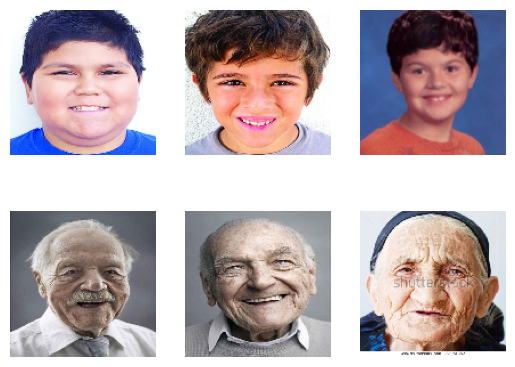

In [18]:

from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('utkface_128.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [20]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.initializers import RandomNormal

In [21]:
def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME', name='c2d'):
    return Conv2D(output_dim, kernel_size=ks, strides=s, padding=padding,
                  kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), name=name)(input_)

In [22]:
def lrelu(input_,name='lr'):
  return LeakyReLU(alpha=0.2,name=name)(input_)

In [23]:
def iNorm(input_,name='iNorm'):
  return InstanceNormalization(axis=-1,name=name)(input_)

In [24]:
# discriminator model
def build_discriminator(image_shape):
  # weight initialization
	#init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	#C1
	d1 = lrelu(conv2d(in_image,64,4,name='d_c1'),'lr1' )
	 
	# C2
	d2 = lrelu(iNorm(conv2d(d1,128,4,name='d_c2'),'iN2'),'lr2') 
	
	# C3
	d3 = lrelu(iNorm(conv2d(d1,256,4,name='d_c3'),'iN3'),'lr3')
	
	# C4
	d4 = lrelu(iNorm(conv2d(d3,512,4,name='d_c4'),'iN4'),'lr4')
	
	'''
	# second last output layer
	d = conv2d(in_image,128,3,1) 
	d = iNorm(d)  
	d = lrelu(d) 
	'''

	#  output

	d5 = conv2d(d4,1,4,1,name='d_c5')  #Conv2D(1, 4,1, padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, d5)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [25]:
disc=build_discriminator(dataB[0].shape)
disc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 d_c1 (Conv2D)               (None, 64, 64, 64)        3136      
                                                                 
 lr1 (LeakyReLU)             (None, 64, 64, 64)        0         
                                                                 
 d_c3 (Conv2D)               (None, 32, 32, 256)       262400    
                                                                 
 iN3 (InstanceNormalization)  (None, 32, 32, 256)      512       
                                                                 
 lr3 (LeakyReLU)             (None, 32, 32, 256)       0         
                                                                 
 d_c4 (Conv2D)               (None, 16, 16, 512)       209766

c:\Users\surya\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
def padd3(input_):
  import tensorflow as tf
  return tf.pad(input_, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")

def padd1(input_):
  import tensorflow as tf
  return tf.pad(input_, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")  

In [27]:
from keras.layers import Add,Lambda
def res_block(input_,nf=64,ks=3,s=1,name='res_blk'):
  p=int((ks-1)/2)
  y=Lambda(padd1)(input_) #(tf.pad(input_,[[0,0],[p,p],[p,p],[0,0]],'REFLECT'))
  
  y=iNorm(conv2d(y,nf,ks,s,padding='VALID',name=name+'_c1'),name=name+'_iN1')
  
  y=Lambda(padd1)(y) #(tf.pad(tf.nn.relu(y),[[0,0],[p,p],[p,p],[0,0]],'REFLECT'))
  
  y=iNorm(conv2d(y,nf,ks,s,padding='VALID',name=name+'_c2'),name=name+'_iN2')
  
  
  y1=keras.layers.Add()([y,input_])
  
  return y1
     

In [28]:
def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME',name='dc2d'):
  #Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  
  dcv=Conv2DTranspose(output_dim,(ks,ks),strides=(s,s),padding=padding,kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),name=name)(input_)
  
  return dcv

In [29]:
from keras.layers import Lambda,Conv2DTranspose

def build_generator(image_shape):
  nf=64 # num filters for first layer 
  input_=Input(shape=(128,128,3))
  c0 = Lambda(padd3)(input_)
  
  c1 = Activation('relu')(iNorm(conv2d(c0, nf, 7, 1, padding='VALID', name='g_e1_c'), 'g_e1_bn'))
  c2 = Activation('relu')(iNorm(conv2d(c1, nf*2, 3, 2, name='g_e2_c'), 'g_e2_bn'))
  c3 = Activation('relu')(iNorm(conv2d(c2, nf*4 , 3, 2, name='g_e3_c'), 'g_e3_bn'))

  r1 = res_block(c3, nf*4, name='g_r1')
  r2 = res_block(r1, nf*4, name='g_r2')
  r3 = res_block(r2, nf*4, name='g_r3')
  r4 = res_block(r3, nf*4, name='g_r4')
  r5 = res_block(r4, nf*4, name='g_r5')
  r6 = res_block(r5, nf*4, name='g_r6')
  r7 = res_block(r6, nf*4, name='g_r7')
  r8 = res_block(r7, nf*4, name='g_r8')
  r9 = res_block(r8, nf*4, name='g_r9')
  
  
  d1=Conv2DTranspose(nf*2, (3,3), strides=(2,2), padding='same', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),name='g_d1_dc')(r9)
  
  d1=Activation('relu')(iNorm(d1,name='g_d1_bn'))

  d2=Conv2DTranspose(nf, (3,3), strides=(2,2), padding='same', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),name='g_d2_dc')(d1)
  

  d2=Activation('relu')(iNorm(d2,name='g_d2_bn'))

  d2 = Lambda(padd3)(d2)#(tf.pad(d2, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT"))

  

  d3=conv2d(d2, 3 , 7, 1, padding='VALID', name='g_pred_c')

  

  pred=Activation('tanh')(d3)

  model=Model(input_,pred)
  

  return model

In [30]:
gen=build_generator(dataA[0].shape)
gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 g_e1_c (Conv2D)                (None, 128, 128, 64  9472        ['lambda[0][0]']                 
                                )                                                                 
                                                                                            

In [31]:
def build_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model
     

In [32]:
def get_subsample(dataset):

    t1=np.random.randint(900)
    t2=np.random.randint(1200,2000)
    t3=np.random.randint(2500,2800)
    return np.vstack((dataset[0][t1:t1+300],dataset[0][t2:t2+400],dataset[0][t3:t3+300])),np.vstack((dataset[1][t1:t1+300], dataset[1][t2:t2+400],dataset[1][t3:t3+300]))

In [33]:
def get_subsample2(dataset):
  t0=np.random.randint(250)
  t1=np.random.randint(300)
  t2=np.random.randint(1200,2000)
  t3=np.random.randint(2500,2800)
  return np.vstack((dataset[0][t1:t1+800],dataset[0][t2:t2+200])),np.vstack((dataset[1][t1:t1+100], dataset[2][t0:t0+900]))

In [34]:
def load_real_samples2(filename):
  data = load(filename)
  X1,X2,X3 = data['arr_0'],data['arr_1'],data['arr_2']
  X1= (X1-127.5)/127.5
  X2 = (X2-127.5)/127.5
  X3 = (X3-127.5)/127.5
  return X1,X2,X3

In [35]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y
 
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
  
# save the generator models to file
def save_models2(step, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
  # save the first discriminator model A
	filename3 = 'd_model_A_%06d.h5' % (step+1)
	d_model_A.save(filename3)
  # save the first discriminator model B
	filename4 = 'd_model_B_%06d.h5' % (step+1)
	d_model_B.save(filename4)
	print('>Saved: %s , %s , %s and %s' % (filename1, filename2,filename3,filename4))  

In [36]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):

	pyplot.figure(
    figsize=(15, 8),
    dpi=120)
 
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [37]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [38]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size,n_epochs):
	# define properties of the training run
	n_epochs, n_batch, = n_epochs, batch_size
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = get_subsample(dataset)
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models2(i, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B)

In [39]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
# load image data
dataset = load_real_samples('utkface_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = build_generator(image_shape)
# generator: B -> A
g_model_BtoA = build_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = build_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = build_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = build_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = build_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=2,n_epochs=25)
#train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=1)

Loaded (2000, 128, 128, 3) (2000, 128, 128, 3)
1/1 [==============================] - 1s 515ms/step
>1, dA[0.830,0.750] dB[0.662,0.779] g[16.385,17.545]
1/1 [==============================] - 0s 18ms/step
>2, dA[9.453,0.794] dB[9.346,0.685] g[17.879,15.729]
1/1 [==============================] - 0s 20ms/step
>3, dA[2.720,0.565] dB[6.293,0.483] g[15.783,15.741]
1/1 [==============================] - 0s 20ms/step
>4, dA[0.796,0.761] dB[0.944,0.551] g[15.225,15.687]
1/1 [==============================] - 0s 23ms/step
>5, dA[1.050,1.078] dB[0.445,1.106] g[15.735,16.642]
1/1 [==============================] - 0s 19ms/step
>6, dA[0.810,1.358] dB[0.497,2.531] g[16.151,16.193]
1/1 [==============================] - 0s 21ms/step
>7, dA[0.772,1.545] dB[0.403,1.952] g[15.050,15.863]
1/1 [==============================] - 0s 18ms/step
>8, dA[0.412,1.632] dB[0.371,1.067] g[15.206,17.943]
1/1 [==============================] - 0s 22ms/step
>9, dA[0.593,1.054] dB[0.339,0.714] g[13.828,16.331]
1/1 [==

In [47]:
def show_results( g_model, trainX, n_samples=5,title='A to B'):
  pyplot.figure(
    figsize=(12, 6),
    dpi=120)
  # select a sample of input images
  X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
  X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
  X_in = (X_in + 1) / 2.0
  X_out = (X_out + 1) / 2.0
	# plot real images
  #pyplot.title(title)
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_in[i])
  pyplot.show()
  print("      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ "+title+" ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓")
	# plot translated image
  pyplot.figure(
    figsize=(12, 6),
    dpi=120)
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_out[i])
  pyplot.show()


1/1 [==============================] - 0s 103ms/step


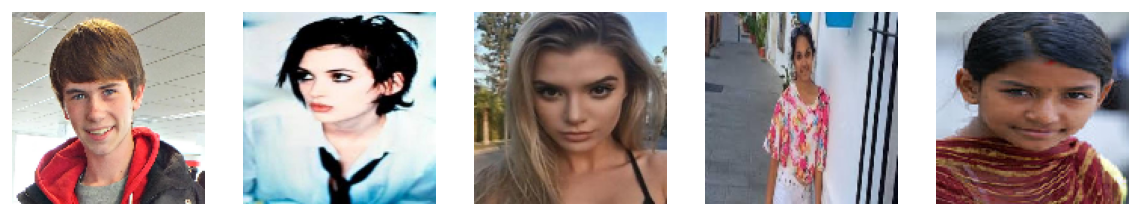

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


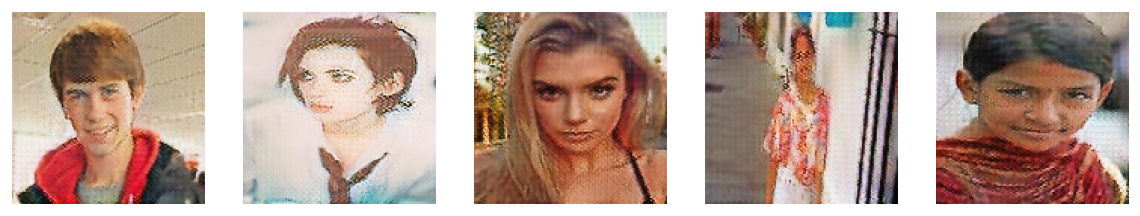

In [48]:
trainA, trainB = dataset
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

1/1 [==============================] - 0s 103ms/step


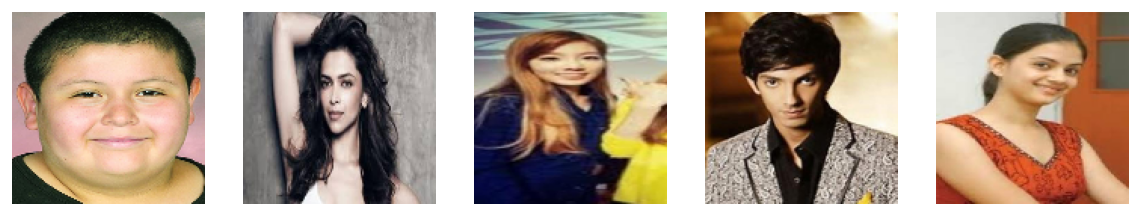

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


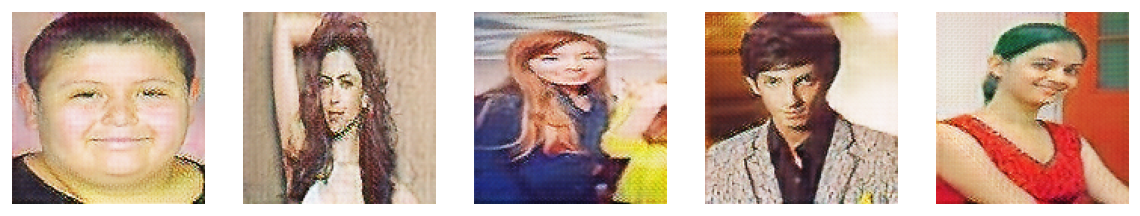

In [49]:
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

1/1 [==============================] - 0s 98ms/step


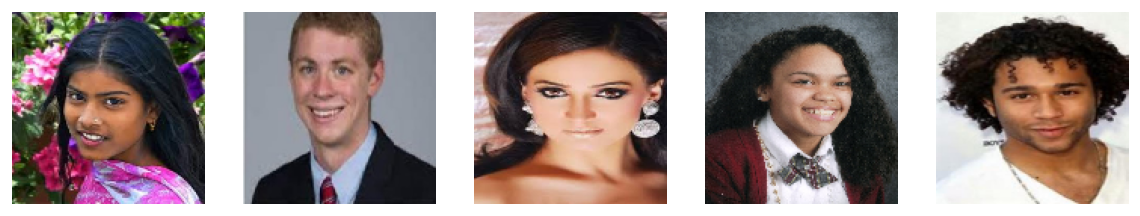

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


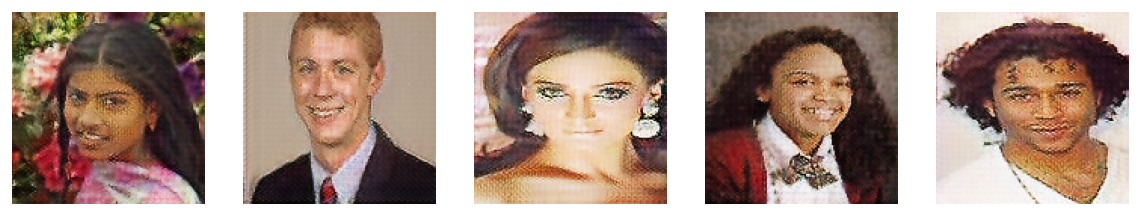

In [50]:
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

1/1 [==============================] - 0s 100ms/step


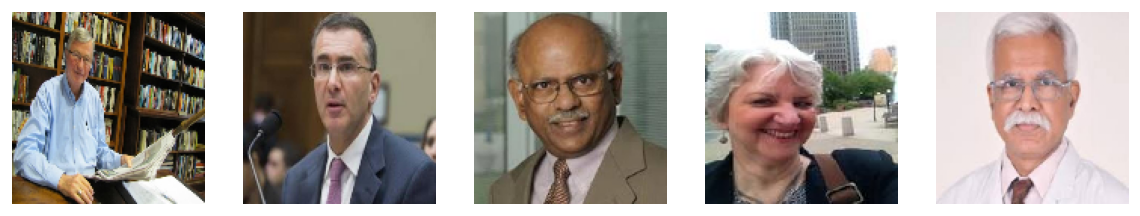

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


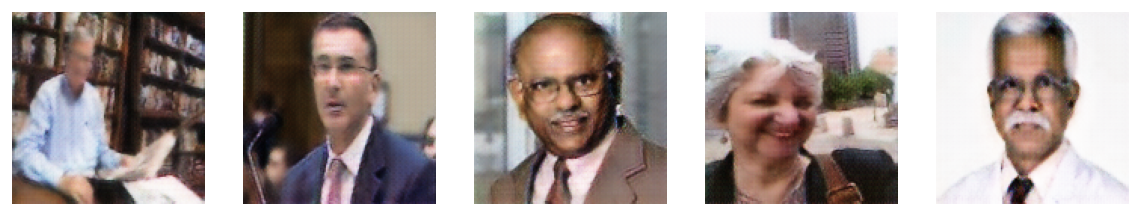

In [51]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

1/1 [==============================] - 0s 103ms/step


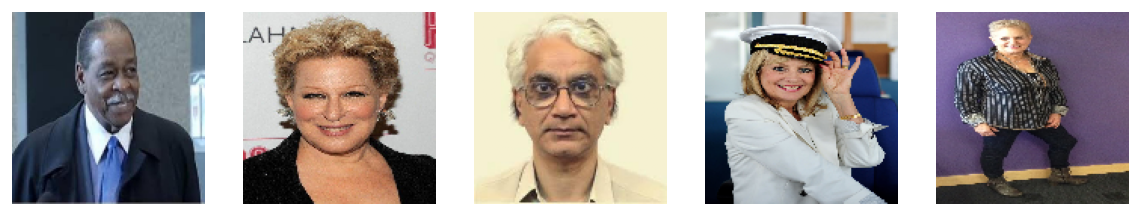

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


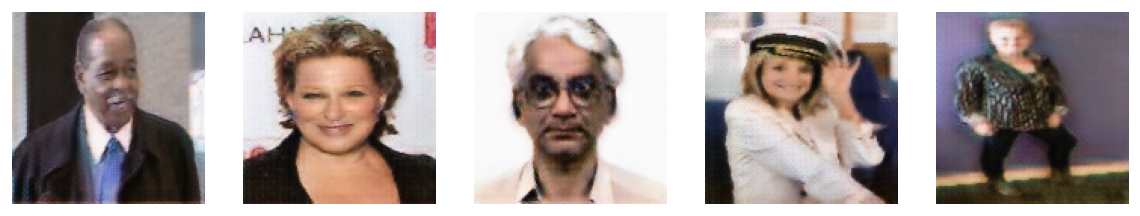

In [52]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

1/1 [==============================] - 0s 98ms/step


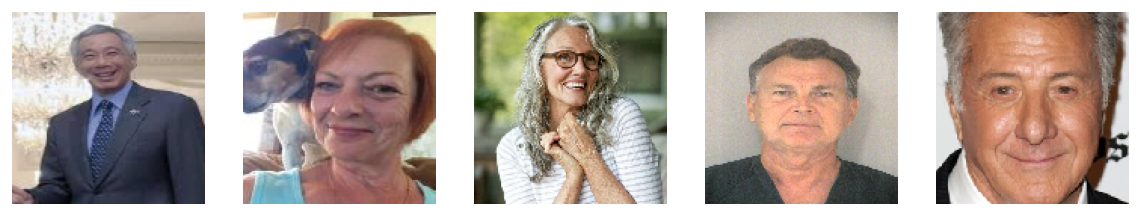

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


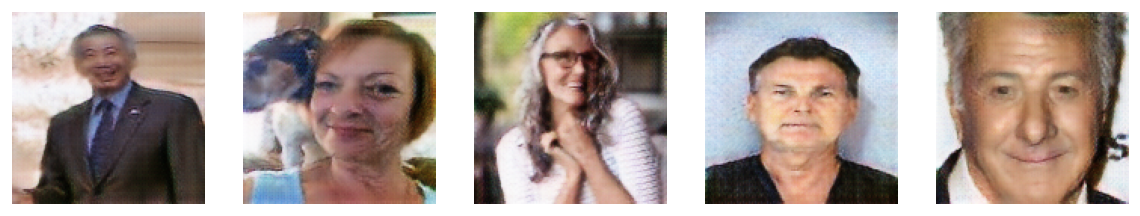

In [53]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

1/1 [==============================] - 0s 108ms/step


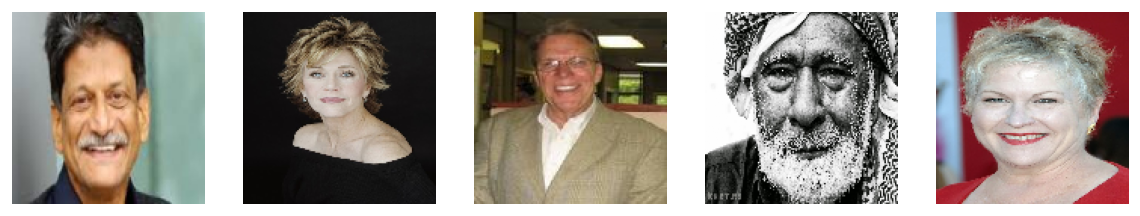

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


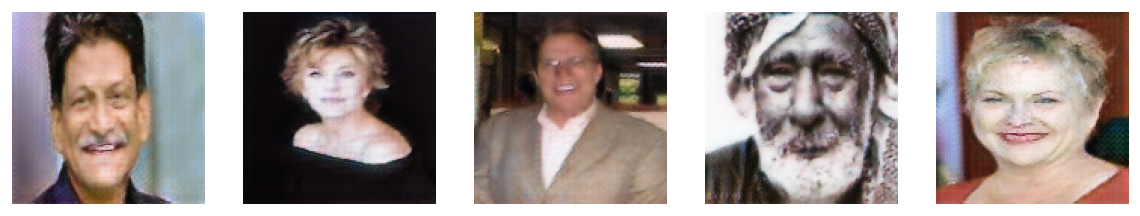

In [54]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')